# Static Analysis

**Static program analysis** is the analysis of computer software performed without executing any programs, in contrast with **dynamic analysis**, which is performed on programs during their execution.

We only focus on binary analysis here, not symbolic analysis.

[Wiki] The Portable Executable (PE) format is a file format for executables, object code, DLLs and others used in 32-bit and 64-bit versions of Windows operating systems. The PE format is a data structure that encapsulates the information necessary for the Windows OS loader to manage the wrapped executable code. This includes dynamic library references for linking, API export and import tables, resource management data and local storage data.

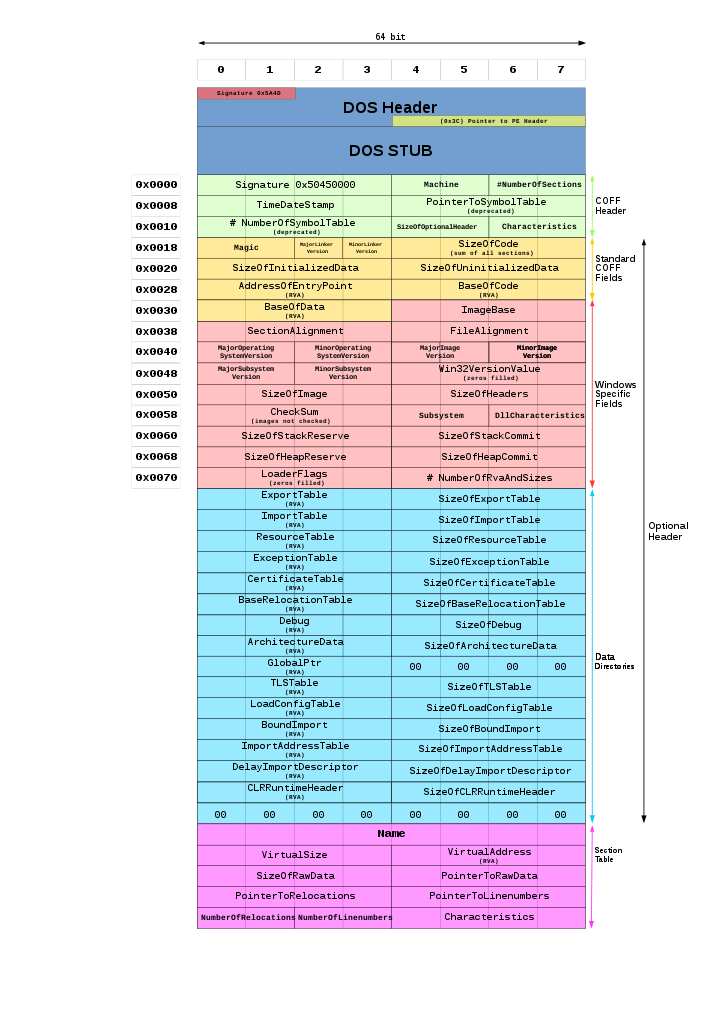

### Get Example Files

In [1]:
# Get a 32-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe -O putty32.exe

--2022-03-15 01:12:49--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.76/w32/putty.exe [following]
--2022-03-15 01:12:49--  https://the.earth.li/~sgtatham/putty/0.76/w32/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1180904 (1.1M) [application/x-msdos-program]
Saving to: ‘putty32.exe’

putty32.exe         100%[===================>]   1.13M  --.-KB/s    in 0.07s   

2022-03-15 01:12:50 (15.5 MB/s) - ‘putty32.exe’ saved [1180904/1180904]



In [2]:
# Get a 64-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe -O putty64.exe

--2022-03-15 01:12:57--  https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.76/w64/putty.exe [following]
--2022-03-15 01:12:58--  https://the.earth.li/~sgtatham/putty/0.76/w64/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1273576 (1.2M) [application/x-msdos-program]
Saving to: ‘putty64.exe’

putty64.exe         100%[===================>]   1.21M  --.-KB/s    in 0.07s   

2022-03-15 01:12:58 (16.6 MB/s) - ‘putty64.exe’ saved [1273576/1273576]



In [3]:
!ls -al

total 2416
drwxr-xr-x 1 root root    4096 Mar 15 01:12 .
drwxr-xr-x 1 root root    4096 Mar 15 01:12 ..
drwxr-xr-x 1 root root    4096 Mar  9 14:47 .config
-rw-r--r-- 1 root root 1180904 Jul 10  2021 putty32.exe
-rw-r--r-- 1 root root 1273576 Jul 10  2021 putty64.exe
drwxr-xr-x 1 root root    4096 Mar  9 14:48 sample_data


### EXE file?

using file extension is a stupid way

In [4]:
def isExe(fp):
    if fp.endswith("exe"):
        return True
    else:
        return False

In [5]:
isExe("putty32.exe")

True

### MZ (DOS) file?

In [6]:
def isMZ(fp):
    with open(fp, 'rb') as hnd:
        if hnd.read(2) == b"MZ":
            return True
        else:
            return False

In [7]:
isMZ("putty32.exe")

True

In [8]:
isMZ("putty64.exe")

True

### PE file?

In [9]:
def isPE(fp):
  try:
    with open(fp, 'rb') as hnd:
      if hnd.read(2) != b"MZ":
        return False
      hnd.seek(0x3c, 0)
      
      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      if hnd.read(4) == b"PE\0\0":
        return True
      else:
        print("isMZ, not PE.")
        return False
  except:
    return False

In [10]:
isPE("/content/putty32.exe")

True

### Architecture? (Machine)

In [11]:
def machine(fp):
  try:
    with open(fp, 'rb') as hnd:
      hnd.seek(0x3c, 0)
      
      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      hnd.read(4)
      machine = struct.unpack("<H", hnd.read(2))[0]

      if machine == 332: # IMAGE_FILE_MACHINE_I386
        return "IA-32 (32-bit x86)"
      elif machine == 512: #IMAGE_FILE_MACHINE_IA64:
        return "IA-64 (Itanium)"
      elif machine == 34404: #IMAGE_FILE_MACHINE_AMD64:
        return "AMD64 (64-bit x86)"
      else:
        return "Unknown architecture"
  except:
    return "Exception"

In [12]:
machine("/content/putty32.exe")

'IA-32 (32-bit x86)'

In [13]:
machine("/content/putty64.exe")

'AMD64 (64-bit x86)'

Microsoft has a mapping table of all machine types and their values. https://docs.microsoft.com/en-us/windows/win32/debug/pe-format

### Hex representation

In [14]:
import binascii

def printHex(fp, limit = 64):
  with open(fp, 'rb') as f:
    content = f.read()
    
    i = 0
    for b in content:
      print(format(b, "02x"), " ", end="")
      if i% 8 == 7:
        print("")
      i += 1
      if i == limit:
        break

In [15]:
printHex("/content/putty32.exe", limit = 160)

4d  5a  78  00  01  00  00  00  
04  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
40  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  78  00  00  00  
0e  1f  ba  0e  00  b4  09  cd  
21  b8  01  4c  cd  21  54  68  
69  73  20  70  72  6f  67  72  
61  6d  20  63  61  6e  6e  6f  
74  20  62  65  20  72  75  6e  
20  69  6e  20  44  4f  53  20  
6d  6f  64  65  2e  24  00  00  
50  45  00  00  4c  01  06  00  
bb  6d  e9  60  00  00  00  00  
00  00  00  00  e0  00  02  01  
0b  01  0e  00  00  60  09  00  
00  56  08  00  00  00  00  00  


Question: where are the DOS and PE signatures?

### Hash

[Wiki] A hash function is any function that can be used to map data of arbitrary size to fixed-size values. The values returned by a hash function are called hash values, digests, or simply hashes. A good hash function should map the expected inputs as evenly as possible over its output range.

Please watch the video. 
https://www.youtube.com/watch?v=l53cqhIPZho

In [16]:
import hashlib

#### MD5 and SHA265

You can check it against with the announced hash values at the end of this page. https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html

In [17]:
filenamepath = "putty32.exe"
md5_value = hashlib.md5(open(filenamepath, 'rb').read()).hexdigest()
print(md5_value)

2a5868f10c09b783d8d96c1f1efac28f


In [18]:
sha256_value = hashlib.sha256(open(filenamepath, 'rb').read()).hexdigest()
print(sha256_value)

7a43789216ce242524e321d2222fa50820a532e29175e0a2e685459a19e09069


#### GPG

Check the calculated (GNU Privacy Guard) GPG value against with the value in [PuTTY web page](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html). Google "digital signature" first.

* Signature ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html))
* Public Key ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/keys.html))



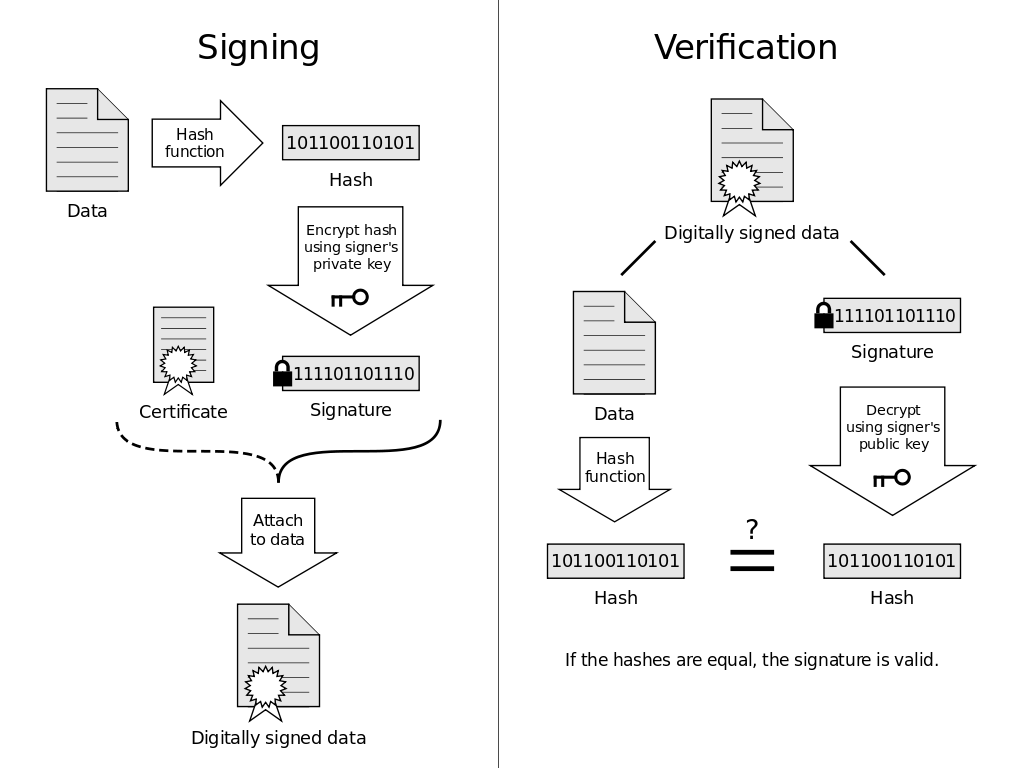

In [19]:
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg

--2022-03-15 01:27:05--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.76/w32/putty.exe.gpg [following]
--2022-03-15 01:27:05--  https://the.earth.li/~sgtatham/putty/0.76/w32/putty.exe.gpg
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 438 [application/pgp-signature]
Saving to: ‘putty.exe.gpg’

putty.exe.gpg       100%[===================>]     438  --.-KB/s    in 0s      

2022-03-15 01:27:05 (90.6 MB/s) - ‘putty.exe.gpg’ saved [438/438]



In [27]:
!wget https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2021.asc

--2022-03-15 01:29:10--  https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2021.asc
Resolving www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)... 212.13.197.231, 2001:ba8:1e3::
Connecting to www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)|212.13.197.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3061 (3.0K) [text/plain]
Saving to: ‘release-2021.asc.1’

release-2021.asc.1  100%[===================>]   2.99K  --.-KB/s    in 0s      

2022-03-15 01:29:10 (193 MB/s) - ‘release-2021.asc.1’ saved [3061/3061]



In [24]:
!gpg --import release-2021.asc

gpg: key E4F83EA2AA4915EC: 1 signature not checked due to a missing key
gpg: key E4F83EA2AA4915EC: public key "PuTTY Releases <putty@projects.tartarus.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: no ultimately trusted keys found


In [25]:
!gpg --verify putty.exe.gpg putty32.exe

gpg: Signature made Sat 17 Jul 2021 10:32:18 AM UTC
gpg:                using RSA key E27394ACA3F9D9049522E0546289A25F4AE8DA82
gpg: Good signature from "PuTTY Releases <putty@projects.tartarus.org>" [expired]
gpg: Note: This key has expired!
Primary key fingerprint: E273 94AC A3F9 D904 9522  E054 6289 A25F 4AE8 DA82


Note: you may need to change the keyname from release-20xx.asc to correct name, since the key may be expired.

# Virustotal

https://www.virustotal.com/gui/home/upload

Try to search 'loadmony', pick one of them and read its info.

# pefile


In [28]:
!pip install pefile

     |████████████████████████████████| 72 kB 531 kB/s 
  Created wheel for pefile: filename=pefile-2021.9.3-py3-none-any.whl size=68844 sha256=9c6d04169a2d0aa0c98d8a54f420b57fffea0308dd6b75e3de83ed1d3aee165b
  Stored in directory: /root/.cache/pip/wheels/50/be/9b/d19a6151b9c6e303f823faedf03193d7e90dac4009a0bdafeb
Successfully built pefile


In [29]:
import pefile

### File Type

In [30]:
filenamepath = "putty32.exe"

pef = pefile.PE(filenamepath, fast_load = False)

In [31]:
print(pef.is_dll())
print(pef.is_driver())
print(pef.is_exe())

False
False
True


### Machine, Timestamp, imphash

In [32]:
print(pef.FILE_HEADER.Machine)

332


In [33]:
import time
timestamp = pef.FILE_HEADER.TimeDateStamp
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp)))

2021-07-10 09:51:55


In [34]:
print(pef.get_imphash())

ddf7967f271d2def449d78bf72166fcb


### Section and Entropy

In [35]:
def printSecEntropy(filenamepath):
  try:
    pef = pefile.PE(filenamepath, fast_load = False)

    total_size = 0
    accumulated_entropy = 0.0
    
    for sec in pef.sections:
      e = sec.get_entropy()
      m = sec.get_hash_md5()

      print(sec.Name, hex(sec.VirtualAddress), hex(sec.Misc_VirtualSize), sec.SizeOfRawData, e, m)

      accumulated_entropy += sec.SizeOfRawData*e
      total_size += sec.SizeOfRawData
    print('entropy', accumulated_entropy/total_size if total_size !=0 else 'None')
  except:
    print("Error")

In [36]:
printSecEntropy("putty32.exe")

b'.text\x00\x00\x00' 0x1000 0x95f6d 614400 6.621174973805228 53d53e5ef7971dfa93a09c705295cd2f
b'.rdata\x00\x00' 0x97000 0x295fc 169472 5.798055557391564 6021f9f370ced8ab0121ffaef3a0c34b
b'.data\x00\x00\x00' 0xc1000 0x3fcc 3072 2.0188133614460364 782a52ab4d3f047c09fb9809e24e88ef
b'.00cfg\x00\x00' 0xc5000 0x4 512 0.06116285224115448 c4f412638a6a577b82594966facbc1da
b'.rsrc\x00\x00\x00' 0xc6000 0x53720 342016 7.8296479644999195 439cfdcdb280386114aac06add148745
b'.reloc\x00\x00' 0x11a000 0x7a00 31232 6.724295461653104 6afedbd2f4e2fe29d1cb059b29b66e50
entropy 6.844784854226108


### Packing

Malware sometimes packs itself with packing tool, because it can change its appearance for not being detected by antivirus engine.

A famous packer is UPX (https://en.wikipedia.org/wiki/UPX). Take a look at its [manual file](https://linux.die.net/man/1/upx).

However, these packing tools have "signature" as well. See https://github.com/cuckoosandbox/cuckoo/blob/master/cuckoo/private/peutils/UserDB.TXT

In [37]:
!apt-get install upx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'upx-ucl' instead of 'upx'
The following additional packages will be installed:
  libucl1
The following NEW packages will be installed:
  libucl1 upx-ucl
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 401 kB of archives.
After this operation, 2,083 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libucl1 amd64 1.03+repack-4 [23.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 upx-ucl amd64 3.94-4 [377 kB]
Fetched 401 kB in 0s (4,206 kB/s)
Selecting previously unselected package libucl1:amd64.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../libucl1_1.03+repack-4_amd64.deb ...
Unpacking libucl1:amd64 (1.03+repack-4) ...
Selecting previously unselected package upx-ucl.
Preparing to unpack .../upx-ucl_3.94-4_amd64.deb ...
Unpacking 

In [38]:
!cp putty32.exe putty32_packed.exe

In [39]:
!upx putty32_packed.exe

                       Ultimate Packer for eXecutables
                          Copyright (C) 1996 - 2017
UPX 3.94        Markus Oberhumer, Laszlo Molnar & John Reiser   May 12th 2017

        File size         Ratio      Format      Name
   --------------------   ------   -----------   -----------
   1180904 ->    768232   65.05%    win32/pe     putty32_packed.exe

Packed 1 file.


In [40]:
!ls -al

total 3184
drwxr-xr-x 1 root root    4096 Mar 15 01:31 .
drwxr-xr-x 1 root root    4096 Mar 15 01:12 ..
drwxr-xr-x 1 root root    4096 Mar  9 14:47 .config
-rw-r--r-- 1 root root 1180904 Jul 10  2021 putty32.exe
-rw-r--r-- 1 root root  768232 Mar 15 01:31 putty32_packed.exe
-rw-r--r-- 1 root root 1273576 Jul 10  2021 putty64.exe
-rw-r--r-- 1 root root     438 Jul 17  2021 putty.exe.gpg
-rw-r--r-- 1 root root    2090 Aug 26  2018 release-2018.asc
-rw-r--r-- 1 root root    3061 Aug 15  2021 release-2021.asc
-rw-r--r-- 1 root root    3061 Aug 15  2021 release-2021.asc.1
drwxr-xr-x 1 root root    4096 Mar  9 14:48 sample_data


In [41]:
print(isPE("putty32_packed.exe"))
print(machine("putty32_packed.exe"))
print(hashlib.md5(open("putty32_packed.exe", 'rb').read()).hexdigest())

True
IA-32 (32-bit x86)
43ea6093d2762f26ed95ef1dd036fd93


In [42]:
!gpg --verify putty.exe.gpg putty32_packed.exe

gpg: Signature made Sat 17 Jul 2021 10:32:18 AM UTC
gpg:                using RSA key E27394ACA3F9D9049522E0546289A25F4AE8DA82
gpg: BAD signature from "PuTTY Releases <putty@projects.tartarus.org>" [expired]


In [43]:
# pip install pefile
import peutils

In [44]:
!wget https://raw.githubusercontent.com/cuckoosandbox/cuckoo/master/cuckoo/private/peutils/UserDB.TXT

--2022-03-15 01:32:19--  https://raw.githubusercontent.com/cuckoosandbox/cuckoo/master/cuckoo/private/peutils/UserDB.TXT
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 499709 (488K) [text/plain]
Saving to: ‘UserDB.TXT’

UserDB.TXT          100%[===================>] 488.00K  --.-KB/s    in 0.02s   

2022-03-15 01:32:19 (29.7 MB/s) - ‘UserDB.TXT’ saved [499709/499709]



In [45]:
# There are some problems in the UserDB.TXT
with open("UserDB.TXT", "rb") as f:
  w = open("UserDB_.TXT", "wb")
  while True:
    line = f.readline()
    if line:
      try:
        line.decode('utf8')
        w.write(line)
      except:
        print("skip", str(line))
    else:
      w.close()
      break

skip b'[PcShare \xce\xc4\xbc\xfe\xc0\xa6\xb0\xf3\xc6\xf7 v4.0 -> \xce\xde\xbf\xc9\xb7\xc7\xd2\xe9]\r\n'
skip b'[UPX-SCRAMBLER 3.06 -> \xa9OnT\xaeoL]\r\n'


In [46]:
sig_db = peutils.SignatureDatabase("UserDB_.TXT")

matches = sig_db.match(pef)
print("Packed:", matches)

Packed: None


In [47]:
packed_pef = pefile.PE("putty32_packed.exe", fast_load=False)

packed_matches = sig_db.match(packed_pef)
print("Packed:", packed_matches)

Packed: ['UPX 2.90 [LZMA] -> Markus Oberhumer, Laszlo Molnar & John Reiser']


In [48]:
printSecEntropy("putty32_packed.exe")

b'UPX0\x00\x00\x00\x00' 0x1000 0x73000 0 0.0 d41d8cd98f00b204e9800998ecf8427e
b'UPX1\x00\x00\x00\x00' 0x74000 0xb5000 740352 7.867527273087528 c2994af27e02d98eab34b88dcff74a18
b'.rsrc\x00\x00\x00' 0x129000 0x2000 8192 4.145450830314121 4350318c9d56e6c15c57264045290f63
entropy 7.8267931943704445


Question: what value of entropy is appropriate?

### Libraries

In [ ]:
def printLibraries(pef):
  try:
    for entry in pef.DIRECTORY_ENTRY_IMPORT:
      print(entry.dll.decode("ascii"))
      for imp in entry.imports:
        print(" ", imp.name.decode("ascii"), end = "")
      print()
  except Exception as e:
    print('Cannot analysis PE sections', e)

In [ ]:
printLibraries(pef)

GDI32.dll
  CreateBitmap  CreateCompatibleBitmap  CreateCompatibleDC  CreateFontA  CreateFontIndirectA  CreatePalette  CreatePen  CreateSolidBrush  DeleteDC  DeleteObject  ExcludeClipRect  ExtTextOutA  ExtTextOutW  GetBkMode  GetCharABCWidthsFloatA  GetCharWidth32A  GetCharWidth32W  GetCharWidthA  GetCharWidthW  GetCharacterPlacementW  GetDeviceCaps  GetObjectA  GetPixel  GetStockObject  GetTextExtentExPointA  GetTextExtentPoint32A  GetTextMetricsA  IntersectClipRect  LineTo  MoveToEx  Polyline  RealizePalette  Rectangle  SelectObject  SelectPalette  SetBkColor  SetBkMode  SetMapMode  SetPaletteEntries  SetPixel  SetTextAlign  SetTextColor  TextOutA  TranslateCharsetInfo  UnrealizeObject  UpdateColors
USER32.dll
  AppendMenuA  BeginPaint  CheckDlgButton  CheckMenuItem  CheckRadioButton  CloseClipboard  CreateCaret  CreateDialogParamA  CreateMenu  CreatePopupMenu  CreateWindowExA  CreateWindowExW  DefDlgProcA  DefWindowProcA  DefWindowProcW  DeleteMenu  DestroyCaret  DestroyIcon  Destro

Question: Is there any api that looks suspicious? How do you define 'suspicious'?

### String Analysis

In [49]:
import string

print(string.printable)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [50]:
def my_strings(filenamepath, min_strings_len = 5):
  with open(filenamepath, "rb") as fd:
    result = ""
    for b in fd.read():
      c = chr(b)
      if c in string.printable:
        result += c
      else:
        if len(result) >= min_strings_len:
          yield result
        result = ""

In [51]:
list(my_strings("putty32.exe"))

['!This program cannot be run in DOS mode.$',
 '.text',
 '`.rdata',
 '@.data',
 '.00cfg',
 '@.rsrc',
 '@.reloc',
 'D$\x0cPS',
 ':QPUR',
 '+RQPS',
 'Wh"dK',
 ',;Pj\nU',
 'RWRRj',
 ',$uDSh',
 'WRWWj',
 ',$+l$',
 'PhZ\tK',
 "<3:u'",
 'Gh;*K',
 '\x0chvjK',
 "\x0ch'xJ",
 '\x0chy/K',
 'USWVP1',
 't!98u',
 'USWVP',
 'USWVP',
 '\x0c^_[]',
 '](VVVW',
 'PRSQW',
 'PQjch;',
 '\x0cj&j>',
 'C49s(t',
 '\x0ch6!K',
 'PRVjehl',
 'PQSSW',
 'SRjrWPjsVUjlh',
 't$Djth',
 't$Lh]',
 'WUjeh',
 'PWQjuh',
 'PWQjih',
 'PWQjkh]',
 'PWQjdh8',
 'PWQRhN|J',
 'PWh2$K',
 'Phe!K',
 'Ph\\"K',
 'PUh=!K',
 'PhEYK',
 'SPhw\tK',
 'PhW K',
 'PRUSh ',
 'RhgWK',
 'WRUjmh',
 'PhY;K',
 'SQjuh',
 'PWQUhH',
 'PhIvJ',
 'PRSjrh',
 'H\x0cSQV',
 '\x0chkyJ',
 'PQVRSUhL',
 'QRhfqJ',
 'PVQRh+',
 'PjvhU',
 'PSh3#K',
 'Ph;B@',
 'QRh/yJ',
 'SQRh{',
 'PSQRhPyJ',
 'Ph EK',
 'PSQj8h',
 'Rha?@',
 'PQWhC',
 'PUQS1',
 'PUQS1',
 'Ph$ K',
 'PUQS1',
 'PQShc|J',
 'Pht K',
 'PWQj4h\r',
 'Php"K',
 'Ph~}J',
 'PhatJ',
 'PSQRhtQK',
 'PSQjph',
 "SPj6hR'K",


Question: How to improve this function?

### Byte Sequence

In [52]:
def countByte(filenamepath):
  with open(filenamepath, 'rb') as f:
    byte_dict = {i:0 for i in range(256)}
    for i in f.read():
      byte_dict[i] += 1
  return byte_dict

In [53]:
byte_dict = countByte("putty32.exe")

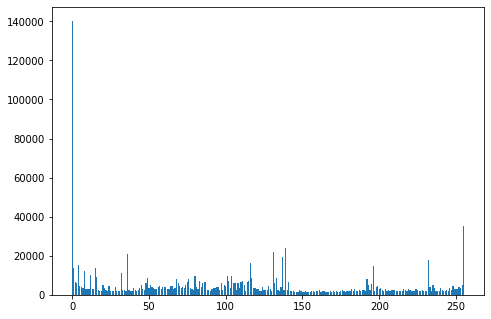

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_dict.values())
plt.show()

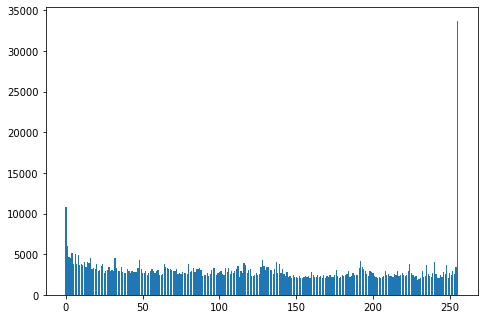

In [55]:
byte_packed_dict = countByte("putty32_packed.exe")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_packed_dict.values())
plt.show()

Question: why? Can you do bi-gram or tri-gram? Need to considering sliding window or not? How many grams needed? Can you find a way to do feature selection on these grams so that we do not need to keep so many features?

### ASM

https://www.capstone-engine.org/lang_python.html

In [56]:
!pip install capstone

     |████████████████████████████████| 2.1 MB 14.0 MB/s 


In [57]:
import capstone
import pefile

pef = pefile.PE("putty32.exe")
entryPoint = pef.OPTIONAL_HEADER.AddressOfEntryPoint
data = pef.get_memory_mapped_image()[entryPoint:]
cs = capstone.Cs(capstone.CS_ARCH_X86, capstone.CS_MODE_32)
for i in cs.disasm(data, 0x1000):
    print("0x%x:\t%s\t%s" %(i.address, i.mnemonic, i.op_str))

串流輸出內容已截斷至最後 5000 行。
0x1f6e4:	push	dword ptr [esi + 0x18]
0x1f6e7:	push	edi
0x1f6e8:	call	0x1f58c
0x1f6ed:	mov	dword ptr [ebp - 4], 0xfffffffe
0x1f6f4:	call	0x1636
0x1f6f9:	ret	
0x1f6fa:	xor	eax, eax
0x1f6fc:	inc	eax
0x1f6fd:	ret	
0x1f6fe:	mov	esp, dword ptr [ebp - 0x18]
0x1f701:	call	0x11091
0x1f706:	int3	
0x1f707:	push	ebp
0x1f708:	mov	ebp, esp
0x1f70a:	mov	edx, dword ptr [ebp + 8]
0x1f70d:	push	ebx
0x1f70e:	push	esi
0x1f70f:	push	edi
0x1f710:	mov	eax, dword ptr [edx + 4]
0x1f713:	test	eax, eax
0x1f715:	je	0x1f78d
0x1f717:	lea	ecx, [eax + 8]
0x1f71a:	cmp	byte ptr [ecx], 0
0x1f71d:	je	0x1f78d
0x1f71f:	test	byte ptr [edx], 0x80
0x1f722:	mov	edi, dword ptr [ebp + 0xc]
0x1f725:	je	0x1f72c
0x1f727:	test	byte ptr [edi], 0x10
0x1f72a:	jne	0x1f78d
0x1f72c:	mov	ebx, dword ptr [edi + 4]
0x1f72f:	xor	esi, esi
0x1f731:	cmp	eax, ebx
0x1f733:	je	0x1f765
0x1f735:	lea	eax, [ebx + 8]
0x1f738:	mov	bl, byte ptr [ecx]
0x1f73a:	cmp	bl, byte ptr [eax]
0x1f73c:	jne	0x1f758
0x1f73e:	test	bl, bl
0x1f740:	je	

Note: we do not cover control-flow graph (CFG)!

## Fuzzy Hash

Get an older version.

In [62]:
!wget https://the.earth.li/~sgtatham/putty/0.75/w32/putty.exe -O putty32_old.exe

--2022-03-15 01:35:45--  https://the.earth.li/~sgtatham/putty/0.75/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1179880 (1.1M) [application/x-msdos-program]
Saving to: ‘putty32_old.exe’

putty32_old.exe     100%[===================>]   1.12M  --.-KB/s    in 0.08s   

2022-03-15 01:35:45 (14.0 MB/s) - ‘putty32_old.exe’ saved [1179880/1179880]



In [59]:
!apt-get install ssdeep

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  ssdeep
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 29.0 kB of archives.
After this operation, 75.8 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ssdeep amd64 2.14-1 [29.0 kB]
Fetched 29.0 kB in 0s (548 kB/s)
Selecting previously unselected package ssdeep.
(Reading database ... 155356 files and directories currently installed.)
Preparing to unpack .../ssdeep_2.14-1_amd64.deb ...
Unpacking ssdeep (2.14-1) ...
Setting up ssdeep (2.14-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [60]:
!ssdeep putty32.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:f13gJnNiQQSA7Ph8NKvKUWqPU5EDvLJPjraFLR5ROWBcs:fWjrHKvKUTPjrkp7Z,"/content/putty32.exe"


In [63]:
!ssdeep putty32_old.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:uUqPzwjzLFgyYyAvnPfcBnrF3+Y8HB+g7lpuPv8S:SQ2/BcBnrFOlB3vuPt,"/content/putty32_old.exe"


In [65]:
import hashlib
print(hashlib.md5(open("putty32.exe", 'rb').read()).hexdigest())
print(hashlib.md5(open("putty32_old.exe", 'rb').read()).hexdigest())

2a5868f10c09b783d8d96c1f1efac28f
a993025aedf905cce301a176f3cd62fb


In [64]:
# https://www.fireeye.com/blog/threat-research/2014/01/tracking-malware-import-hashing.html

print(pefile.PE("putty32.exe").get_imphash())
print(pefile.PE("putty32_old.exe").get_imphash())

ddf7967f271d2def449d78bf72166fcb
ddf7967f271d2def449d78bf72166fcb


Question: take a look at pefile's source code? What is imphash?

In [66]:
!ssdeep -pb *.exe

putty32.exe matches putty64.exe (44)

putty64.exe matches putty32.exe (44)



Note that python has "ssdeep", but it cannot install in colab directly. https://pypi.org/project/ssdeep/

In [81]:
!echo "This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pen." > b.txt

In [82]:
!ssdeep b.txt

ssdeep,1.1--blocksize:hash:hash,filename
3:hMCE3r4FMWF9eKE3r4FMWF9eKE3r4FMWF9eKE3r4FMWF5:hub4gfb4gfb4gfb41,"/content/b.txt"
ssdeep: Did not process files large enough to produce meaningful results


In [84]:
!echo "This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pineapple. This is a book and that is a pen" > a.txt

In [85]:
!ssdeep a.txt

ssdeep,1.1--blocksize:hash:hash,filename
3:hMCE3r4FMWF9eKE3r4FMWF9eKE3r4FMWFIHE3r4FMWFF:hub4gfb4gfb4hb4B,"/content/a.txt"
ssdeep: Did not process files large enough to produce meaningful results
